In [337]:
from pandas import *
import matplotlib.pyplot as plt

1

In [338]:
data_0 = read_csv("C:/Users/Charles Lee/OneDrive - CUHK-Shenzhen/FIN3080_P4/TRD_Dalyr0.csv")
data_1 = read_csv("C:/Users/Charles Lee/OneDrive - CUHK-Shenzhen/FIN3080_P4/TRD_Dalyr1.csv")
data_2 = read_csv("C:/Users/Charles Lee/OneDrive - CUHK-Shenzhen/FIN3080_P4/TRD_Dalyr2.csv")
data_3 = read_csv("C:/Users/Charles Lee/OneDrive - CUHK-Shenzhen/FIN3080_P4/TRD_Dalyr3.csv")
data_4 = read_csv("C:/Users/Charles Lee/OneDrive - CUHK-Shenzhen/FIN3080_P4/TRD_Dalyr4.csv")
data_5 = read_csv("C:/Users/Charles Lee/OneDrive - CUHK-Shenzhen/FIN3080_P4/TRD_Dalyr5.csv")
data_6 = read_csv("C:/Users/Charles Lee/OneDrive - CUHK-Shenzhen/FIN3080_P4/TRD_Dalyr6.csv")

data_main1 = concat([data_0, data_1, data_2, data_3, data_4, data_5, data_6], axis=0, ignore_index=True)
data_main1 = data_main1.rename(columns={'Stkcd': 'code', 'Trddt': 'date', 'Dretnd': 'return'})
data_main1['date'] = to_datetime(data_main1['date'])
data_main1

,code,date,return
0,1,2016-01-04,-0.055046
1,1,2016-01-05,0.006178
2,1,2016-01-06,0.011404
3,1,2016-01-07,-0.051171
4,1,2016-01-08,0.016453
...,...,...,...
5450734,900957,2022-12-26,0.021779
5450735,900957,2022-12-27,0.001776
5450736,900957,2022-12-28,-0.007092
5450737,900957,2022-12-29,-0.005357


2

In [339]:
data_7 = read_csv("C:/Users/Charles Lee/OneDrive - CUHK-Shenzhen/FIN3080_P4/TRD_Dalym.csv")
data_7 = data_7.rename(columns={'Markettype': 'type', 'Trddt': 'date', 'Dretmdeq': 'market return'})
data_7 = data_7[data_7['type'] == 1]
data_7['date'] = to_datetime(data_7['date'])
data_main2 = data_7[['date', 'market return']]
data_main2

,date,market return
4,2016-01-04,-0.087405
9,2016-01-05,-0.012811
14,2016-01-06,0.031834
19,2016-01-07,-0.090405
24,2016-01-08,0.016966
...,...,...
11609,2023-12-25,-0.004500
11615,2023-12-26,-0.009787
11623,2023-12-27,0.007200
11629,2023-12-28,0.015103


3

In [340]:
data_8 = read_csv("C:/Users/Charles Lee/OneDrive - CUHK-Shenzhen/FIN3080_P4/FI_T9.csv")
data_8 = data_8.rename(columns={'Stkcd': 'code', 'Accper': 'ending date of statistic', 'Typrep': 'code for statement type', 'Indcd': 'industry code', 'F090101B': 'EPS', 'ShortName_EN': 'short name'})
data_8 = data_8[data_8['code for statement type'] == 'A']
data_8 = data_8[~(data_8['short name'].str.startswith(('ST ', '*ST ', 'PT ', '*PT ')))]
data_8['ending date of statistic'] = to_datetime(data_8['ending date of statistic'])
data_8.dropna(subset=['industry code'], inplace=True)
data_8 = data_8[~data_8['industry code'].str.startswith('J')]
data_8['month'] = data_8['ending date of statistic'].dt.month
data_8 = data_8[(data_8['month'] == 6) | (data_8['month'] == 12)]

data_8.sort_values(['code', 'ending date of statistic'], inplace=True)

# 使用shift方法创建新列l.EPS，表示上一个月的EPS值
data_8['l.EPS'] = data_8.groupby('code')['EPS'].shift()

# 使用条件过滤和.loc方法进行条件替换操作
data_8.loc[data_8['month'] == 12, 'EPS'] = data_8['EPS'] - data_8['l.EPS']

# 删除辅助列l.EPS
data_8.drop('l.EPS', axis=1, inplace=True)
data_8 = data_8[['code', 'ending date of statistic', 'EPS']]
data_8['EPS_last_year'] = data_8.groupby('code')['EPS'].shift(2)
data_8['UE'] = data_8['EPS'] - data_8['EPS_last_year']
data_8.drop('EPS_last_year', axis=1, inplace=True)
data_8['deviation'] = data_8.groupby('code')['UE'].rolling(window=4).std().reset_index(level=0, drop=True)
data_8['SUE'] = data_8['UE'] / data_8['deviation']
data_8.dropna(inplace=True)

grouped_data = data_8.groupby('ending date of statistic')
data_8['decile'] = grouped_data['SUE'].transform(lambda x: qcut(x, 10, labels=[1,2,3,4,5,6,7,8,9,10]))
data_8 = data_8[['code', 'ending date of statistic', 'decile']]

data_8 = data_8.pivot_table(index='code', columns='ending date of statistic', values='decile', aggfunc='first')
data_8.reset_index(inplace=True)
data_8.columns = [f'{col}_decile' for col in data_8.columns]
data_8.rename(columns={'code_decile': 'code'}, inplace=True)
data_main3 = data_8
data_main3


,code,2015-12-31 00:00:00_decile,2016-06-30 00:00:00_decile,2016-12-31 00:00:00_decile,2017-06-30 00:00:00_decile,2017-12-31 00:00:00_decile,2018-06-30 00:00:00_decile,2018-12-31 00:00:00_decile,2019-06-30 00:00:00_decile,2019-12-31 00:00:00_decile,2020-06-30 00:00:00_decile,2020-12-31 00:00:00_decile,2021-06-30 00:00:00_decile,2021-12-31 00:00:00_decile,2022-06-30 00:00:00_decile,2022-12-31 00:00:00_decile
0,2,10,7,8,10,10,10,10,10,5,5,8,1,1,7,5
1,4,4,5,9,3,2,7,2,4,8,7,9,5,1,NaN,NaN
2,5,4,10,5,1,6,7,8,10,4,3,1,NaN,NaN,NaN,NaN
3,6,4,3,9,7,4,8,5,1,7,7,5,10,2,4,7
4,7,9,8,10,3,2,3,1,6,9,5,3,NaN,NaN,NaN,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4981,900952,3,1,5,9,7,6,10,7,3,7,5,3,1,3,8
4982,900953,9,5,6,7,3,2,1,6,9,6,5,3,1,3,7
4983,900955,NaN,NaN,1,2,9,8,3,4,4,NaN,NaN,NaN,NaN,NaN,NaN
4984,900956,7,7,10,10,2,8,10,8,10,4,NaN,NaN,NaN,NaN,NaN


4

In [341]:
data_9 = read_csv("C:/Users/Charles Lee/OneDrive - CUHK-Shenzhen/FIN3080_P4/IAR_Rept.csv")
data_9 = data_9.rename(columns={'Stkcd': 'code', 'Stknme_en': 'Stock Acronym', 'Reptyp': 'Report Type', 'Accper': 'ending date of statistics', 'Annodt': 'announcement date'})
data_9['announcement date'] = to_datetime(data_9['announcement date'])
data_9['ending date of statistics'] = to_datetime(data_9['ending date of statistics'])

data_9 = data_9[(data_9['Report Type'] == 2) | (data_9['Report Type'] == 4)]
data_9 = data_9[['code', 'ending date of statistics', 'announcement date']]
data_9 = data_9.pivot_table(index='code', columns='ending date of statistics', values='announcement date', aggfunc='first')
data_9.reset_index(inplace=True)
data_9.columns = [f'{col}_announce' for col in data_9.columns]
data_9.rename(columns={'code_announce': 'code'}, inplace=True)

data_main4 = data_9
data_main4

,code,2016-06-30 00:00:00_announce,2016-12-31 00:00:00_announce,2017-06-30 00:00:00_announce,2017-12-31 00:00:00_announce,2018-06-30 00:00:00_announce,2018-12-31 00:00:00_announce,2019-06-30 00:00:00_announce,2019-12-31 00:00:00_announce,2020-06-30 00:00:00_announce,2020-12-31 00:00:00_announce,2021-06-30 00:00:00_announce,2021-12-31 00:00:00_announce,2022-06-30 00:00:00_announce,2022-12-31 00:00:00_announce
0,1,2016-08-12,2017-03-17,2017-08-11,2018-03-15,2018-08-16,2019-03-07,2019-08-08,2020-02-14,2020-08-28,2021-02-02,2021-08-20,2022-03-10,2022-08-18,2023-03-09
1,2,2016-08-22,2017-03-27,2017-08-25,2018-03-27,2018-08-21,2019-03-26,2019-08-21,2020-03-18,2020-08-28,2021-03-31,2021-08-30,2022-03-31,2022-08-31,2023-03-31
2,4,2016-08-31,2017-04-11,2017-08-31,2018-04-28,2018-08-25,2019-04-26,2019-08-31,2020-04-28,2020-08-31,2021-04-28,2021-08-27,2022-04-30,2022-08-25,2023-04-29
3,5,2016-08-25,2017-04-27,2017-08-26,2018-04-21,2018-08-30,2019-04-25,2019-08-29,2020-05-23,2020-08-29,2021-04-30,2021-08-27,2022-04-27,2022-08-27,2023-04-29
4,6,2016-08-19,2017-03-30,2017-08-18,2018-03-30,2018-08-17,2019-03-30,2019-08-16,2020-04-09,2020-08-28,2021-03-31,2021-08-27,2022-04-16,2022-08-25,2023-04-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5346,900952,2016-08-27,2017-03-31,2017-08-25,2018-02-14,2018-08-25,2019-04-17,2019-08-27,2020-04-11,2020-08-29,2021-04-29,2021-08-28,2022-04-29,2022-08-27,2023-04-28
5347,900953,2016-08-27,2017-03-29,2017-08-30,2018-03-31,2018-08-30,2019-04-13,2019-08-31,2020-04-11,2020-08-29,2021-04-09,2021-08-28,2022-04-27,2022-08-31,2023-04-28
5348,900955,2016-08-30,2017-04-28,2017-08-30,2018-04-28,2018-08-30,2019-04-29,2019-08-31,2020-04-30,2020-08-25,2021-04-30,2021-08-31,2022-04-30,NaT,NaT
5349,900956,2016-08-27,2017-04-22,2017-08-26,2018-03-31,2018-08-25,2019-03-23,2019-08-10,2020-04-11,2020-08-15,NaT,NaT,NaT,NaT,NaT


5

In [342]:
data_main = merge(data_main1, data_main2, on=['date'], how='left')
data_main = merge(data_main, data_main3, on=['code'], how='left')
data_main = merge(data_main, data_main4, on=['code'], how='left')

data_main.dropna(inplace=True, ignore_index=True)
data_main

,code,date,return,market return,2015-12-31 00:00:00_decile,2016-06-30 00:00:00_decile,2016-12-31 00:00:00_decile,2017-06-30 00:00:00_decile,2017-12-31 00:00:00_decile,2018-06-30 00:00:00_decile,...,2018-06-30 00:00:00_announce,2018-12-31 00:00:00_announce,2019-06-30 00:00:00_announce,2019-12-31 00:00:00_announce,2020-06-30 00:00:00_announce,2020-12-31 00:00:00_announce,2021-06-30 00:00:00_announce,2021-12-31 00:00:00_announce,2022-06-30 00:00:00_announce,2022-12-31 00:00:00_announce
0,2,2016-07-04,-0.099877,0.022721,10,7,8,10,10,10,...,2018-08-21,2019-03-26,2019-08-21,2020-03-18,2020-08-28,2021-03-31,2021-08-30,2022-03-31,2022-08-31,2023-03-31
1,2,2016-07-05,-0.100045,0.009576,10,7,8,10,10,10,...,2018-08-21,2019-03-26,2019-08-21,2020-03-18,2020-08-28,2021-03-31,2021-08-30,2022-03-31,2022-08-31,2023-03-31
2,2,2016-07-06,0.000505,0.008418,10,7,8,10,10,10,...,2018-08-21,2019-03-26,2019-08-21,2020-03-18,2020-08-28,2021-03-31,2021-08-30,2022-03-31,2022-08-31,2023-03-31
3,2,2016-07-07,-0.049495,0.002856,10,7,8,10,10,10,...,2018-08-21,2019-03-26,2019-08-21,2020-03-18,2020-08-28,2021-03-31,2021-08-30,2022-03-31,2022-08-31,2023-03-31
4,2,2016-07-08,-0.003719,-0.003644,10,7,8,10,10,10,...,2018-08-21,2019-03-26,2019-08-21,2020-03-18,2020-08-28,2021-03-31,2021-08-30,2022-03-31,2022-08-31,2023-03-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2884242,900957,2022-12-26,0.021779,0.012419,6,3,5,10,10,9,...,2018-08-10,2019-03-30,2019-08-10,2020-04-25,2020-08-12,2021-04-09,2021-08-12,2022-04-20,2022-08-16,2023-04-08
2884243,900957,2022-12-27,0.001776,0.006456,6,3,5,10,10,9,...,2018-08-10,2019-03-30,2019-08-10,2020-04-25,2020-08-12,2021-04-09,2021-08-12,2022-04-20,2022-08-16,2023-04-08
2884244,900957,2022-12-28,-0.007092,-0.008585,6,3,5,10,10,9,...,2018-08-10,2019-03-30,2019-08-10,2020-04-25,2020-08-12,2021-04-09,2021-08-12,2022-04-20,2022-08-16,2023-04-08
2884245,900957,2022-12-29,-0.005357,-0.004599,6,3,5,10,10,9,...,2018-08-10,2019-03-30,2019-08-10,2020-04-25,2020-08-12,2021-04-09,2021-08-12,2022-04-20,2022-08-16,2023-04-08


6

In [343]:
data_main['abnormal return'] = data_main['return'] - data_main['market return']
all_mean_ARs = DataFrame()
dates_list = ['2016-06-30 00:00:00', '2016-12-31 00:00:00', '2017-06-30 00:00:00', '2017-12-31 00:00:00', '2018-06-30 00:00:00', '2018-12-31 00:00:00', '2019-06-30 00:00:00', '2019-12-31 00:00:00',  ]
for date in dates_list:
    subset_data = data_main[['code', 'date', 'abnormal return', f'{date}_decile', f'{date}_announce']]
    subset_data['event date'] = subset_data['date'] - subset_data[f'{date}_announce']
    subset_data['event date'] = subset_data['event date'].dt.days
    subset_data = subset_data[(subset_data['event date'] >= -60) & (subset_data['event date'] <= 60)]

    mean_ARs = subset_data.groupby(['event date', f'{date}_decile'])['abnormal return'].mean().reset_index()
    mean_ARs['CAR_' + date] = mean_ARs.groupby(f'{date}_decile')['abnormal return'].cumsum()
    mean_ARs = mean_ARs[[f'{date}_decile', 'event date', 'CAR_' + date]]
    mean_ARs.rename(columns={f'{date}_decile': 'decile'}, inplace=True)
    mean_ARs.sort_values(by=['decile', 'event date'], ascending=True, inplace=True)
    all_mean_ARs = concat([all_mean_ARs, mean_ARs], axis=1)

date = '2020-06-30 00:00:00'
subset_data = data_main[['code', 'date', 'abnormal return', f'{date}_decile', f'{date}_announce']]
subset_data['event date'] = subset_data['date'] - subset_data[f'{date}_announce']
subset_data['event date'] = subset_data['event date'].dt.days
subset_data = subset_data[(subset_data['event date'] >= -60) & (subset_data['event date'] <= 60)]

mean_ARs = subset_data.groupby(['event date', f'{date}_decile'])['abnormal return'].mean().reset_index()
mean_ARs['CAR_' + date] = mean_ARs.groupby(f'{date}_decile')['abnormal return'].cumsum()
mean_ARs = mean_ARs[[f'{date}_decile', 'event date', 'CAR_' + date]]
mean_ARs.rename(columns={f'{date}_decile': 'decile'}, inplace=True)
mean_ARs.sort_values(by=['decile', 'event date'], ascending=True, inplace=True)
all_mean_ARs = concat([all_mean_ARs, mean_ARs], axis=1)
date = '2020-12-31 00:00:00'
subset_data = data_main[['code', 'date', 'abnormal return', f'{date}_decile', f'{date}_announce']]
subset_data['event date'] = subset_data['date'] - subset_data[f'{date}_announce']
subset_data['event date'] = subset_data['event date'].dt.days
subset_data = subset_data[(subset_data['event date'] >= -60) & (subset_data['event date'] <= 60)]


df_cleaned = all_mean_ARs.T.drop_duplicates().T
df_cleaned

C:\Users\Charles Lee\AppData\Local\Temp\ipykernel_14780\615922106.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_data['event date'] = subset_data['date'] - subset_data[f'{date}_announce']
C:\Users\Charles Lee\AppData\Local\Temp\ipykernel_14780\615922106.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_data['event date'] = subset_data['event date'].dt.days
C:\Users\Charles Lee\AppData\Local\Temp\ipykernel_14780\615922106.py:10: FutureWarning: The default of observed=False is deprecated 

,decile,event date,CAR_2016-06-30 00:00:00,CAR_2016-12-31 00:00:00,CAR_2017-06-30 00:00:00,CAR_2017-12-31 00:00:00,CAR_2018-06-30 00:00:00,CAR_2018-12-31 00:00:00,CAR_2019-06-30 00:00:00,CAR_2019-12-31 00:00:00,CAR_2020-06-30 00:00:00
0,1.0,-60.0,-1.631288e-04,-0.003819,-0.001203,-0.001912,-0.004463,0.004647,-0.001808,-0.007631,-0.001787
10,1.0,-59.0,1.597652e-03,-0.004886,-0.003716,-0.006556,-0.002762,0.004939,-0.003120,-0.012853,-0.001016
20,1.0,-58.0,-5.811688e-07,-0.006634,-0.004880,-0.012608,-0.000630,0.000740,-0.006140,-0.013890,0.001282
30,1.0,-57.0,1.690492e-03,-0.010031,-0.007318,-0.013937,-0.001886,0.004292,-0.008179,-0.017055,0.002787
40,1.0,-56.0,3.372913e-03,-0.011851,-0.008768,-0.012897,-0.006732,0.003439,-0.009479,-0.019227,0.005344
...,...,...,...,...,...,...,...,...,...,...,...
1169,10.0,56.0,-4.807795e-02,-0.015906,-0.008048,0.011370,0.062184,0.013322,0.063459,0.019455,0.110988
1179,10.0,57.0,-4.902115e-02,-0.018056,-0.007554,0.009567,0.062627,0.011706,0.062578,0.021056,0.109456
1189,10.0,58.0,-4.769383e-02,-0.018755,-0.008831,0.012309,0.062986,0.009758,0.061812,0.025058,0.108460
1199,10.0,59.0,-4.925700e-02,-0.016068,-0.007969,0.009723,0.057874,0.011669,0.063129,0.024711,0.111834


In [344]:
df_cleaned['mean car'] = df_cleaned[['CAR_2016-06-30 00:00:00', 'CAR_2016-12-31 00:00:00', 'CAR_2017-06-30 00:00:00', 'CAR_2017-12-31 00:00:00', 'CAR_2018-06-30 00:00:00', 'CAR_2018-12-31 00:00:00', 'CAR_2019-06-30 00:00:00', 'CAR_2019-12-31 00:00:00']].mean(axis=1)
result = df_cleaned[['decile', 'event date', 'mean car']]
result

,decile,event date,mean car
0,1.0,-60.0,-0.002044
10,1.0,-59.0,-0.003420
20,1.0,-58.0,-0.005505
30,1.0,-57.0,-0.006553
40,1.0,-56.0,-0.007768
...,...,...,...
1169,10.0,56.0,0.012220
1179,10.0,57.0,0.011613
1189,10.0,58.0,0.012080
1199,10.0,59.0,0.011727


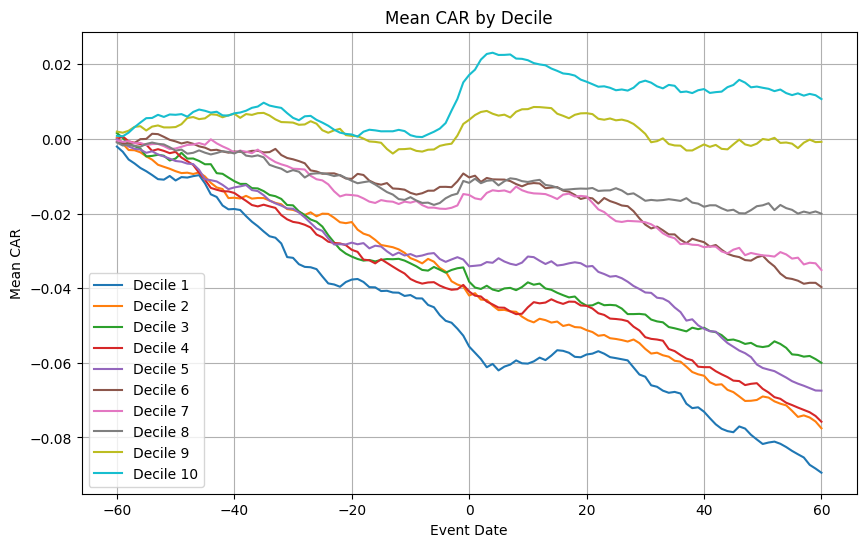

In [345]:
# 创建一个新的图形
plt.figure(figsize=(10, 6))

# 循环遍历每个 decile 列
for decile in range(1, 11):
    # 选择当前 decile 的数据
    decile_data = result[result['decile'] == decile]
    
    # 绘制当前 decile 的 Mean_CAR 线
    plt.plot(decile_data['event date'], decile_data['mean car'], label=f'Decile {decile}')

# 添加标题和标签
plt.title('Mean CAR by Decile')
plt.xlabel('Event Date')
plt.ylabel('Mean CAR')
plt.legend()  # 添加图例

# 显示图形
plt.grid(True)
plt.show()